In [1]:
import sys
import os
os.chdir("..")


In [18]:
import packages

In [3]:

from packages.data_objects.dataset import TorchDataset
from packages.io.torch_dataloaders import get_data_loaders



dataset = TorchDataset(root_folder="/media/lolly/SSD/WAYEEGGAL_dataset/0.69subset_250_eeg_wav")
train_loader, val_loader, test_loader = get_data_loaders(dataset, sets_size={'train': 0.6, 'val': 0.2}, batch_size=32, norm_axes=(0,4), target_norm_axes=(0, 2))


Calculating normalization parameters (input & target): 100%|██████████| 298/298 [00:52<00:00,  5.72it/s]


In [ ]:
import numpy as np
import torch

import matplotlib.pyplot as plt

def _extract_inputs(batch):
    x = batch['input']
    return x

def collect_n_samples(loader, n_samples):
    collected = []
    it = iter(loader)
    while len(collected) < n_samples:
        try:
            batch = next(it)
        except StopIteration:
            break
        x = _extract_inputs(batch).detach().cpu()
        # ensure first dim is batch
        if x.ndim == 0:
            continue
        for i in range(x.shape[0]):
            collected.append(x[i].numpy().ravel())
            if len(collected) >= n_samples:
                break
    if len(collected) == 0:
        raise RuntimeError("No samples collected from loader")
    # return list of 1D arrays -> stack for convenience
    return np.stack(collected)

# collect 32 samples from each loader
train_samples = collect_n_samples(train_loader, 120)
val_samples = collect_n_samples(val_loader, 120)

# flatten values across samples for histogram comparison
train_vals = train_samples.ravel()
val_vals = val_samples.ravel()

# shared bin range
vmin = min(train_vals.min(), val_vals.min())
vmax = max(train_vals.max(), val_vals.max())
bins = 10000

plt.figure(figsize=(9,5))
plt.hist(train_vals, bins=bins, range=(vmin, vmax), density=True, alpha=0.5, label='train (32 samples)')
plt.hist(val_vals,   bins=bins, range=(vmin, vmax), density=True, alpha=0.5, label='val   (32 samples)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution comparison — 32 samples: train vs val')
plt.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [35]:
# Collect samples from train and val loaders
train_samples = collect_n_samples(train_loader, 1000)
val_samples = collect_n_samples(val_loader, 1000)

# Flatten all values
train_vals = train_samples.ravel()
val_vals = val_samples.ravel()

# Calculate percentage outside [-1, 1]
def calculate_outside_percentage(values, lower=-1, upper=1):
    outside_count = np.sum((values < lower) | (values > upper))
    total_count = len(values)
    return (outside_count / total_count) * 100

train_outside11 = calculate_outside_percentage(train_vals, -1, 1)
val_outside11 = calculate_outside_percentage(val_vals, -1, 1)

train_outside22 = calculate_outside_percentage(train_vals, -2, 2)
val_outside22 = calculate_outside_percentage(val_vals, -2, 2)

train_outside55 = calculate_outside_percentage(train_vals, -5, 5)
val_outside55 = calculate_outside_percentage(val_vals, -5, 5)

print(f"Percentage of values outside [-1, 1]: Train: {train_outside11:.4f}%, Val: {val_outside11:.4f}%")
print(f"Percentage of values outside [-2, 2]: Train: {train_outside22:.4f}%, Val: {val_outside22:.4f}%")
print(f"Percentage of values outside [-5, 5]: Train: {train_outside55:.4f}%, Val: {val_outside55:.4f}%")

# Additional statistics
print(f"\nTrain - Min: {train_vals.min():.4f}, Max: {train_vals.max():.4f}")
print(f"Val   - Min: {val_vals.min():.4f}, Max: {val_vals.max():.4f}")

Percentage of values outside [-1, 1]: Train: 17.6078%, Val: 17.5195%
Percentage of values outside [-2, 2]: Train: 3.8053%, Val: 3.7380%
Percentage of values outside [-5, 5]: Train: 0.2491%, Val: 0.2214%

Train - Min: -1.7517, Max: 51.8023
Val   - Min: -1.7540, Max: 33.9865


In [27]:
next(iter(val_loader))['target'].shape

torch.Size([32, 32, 250])

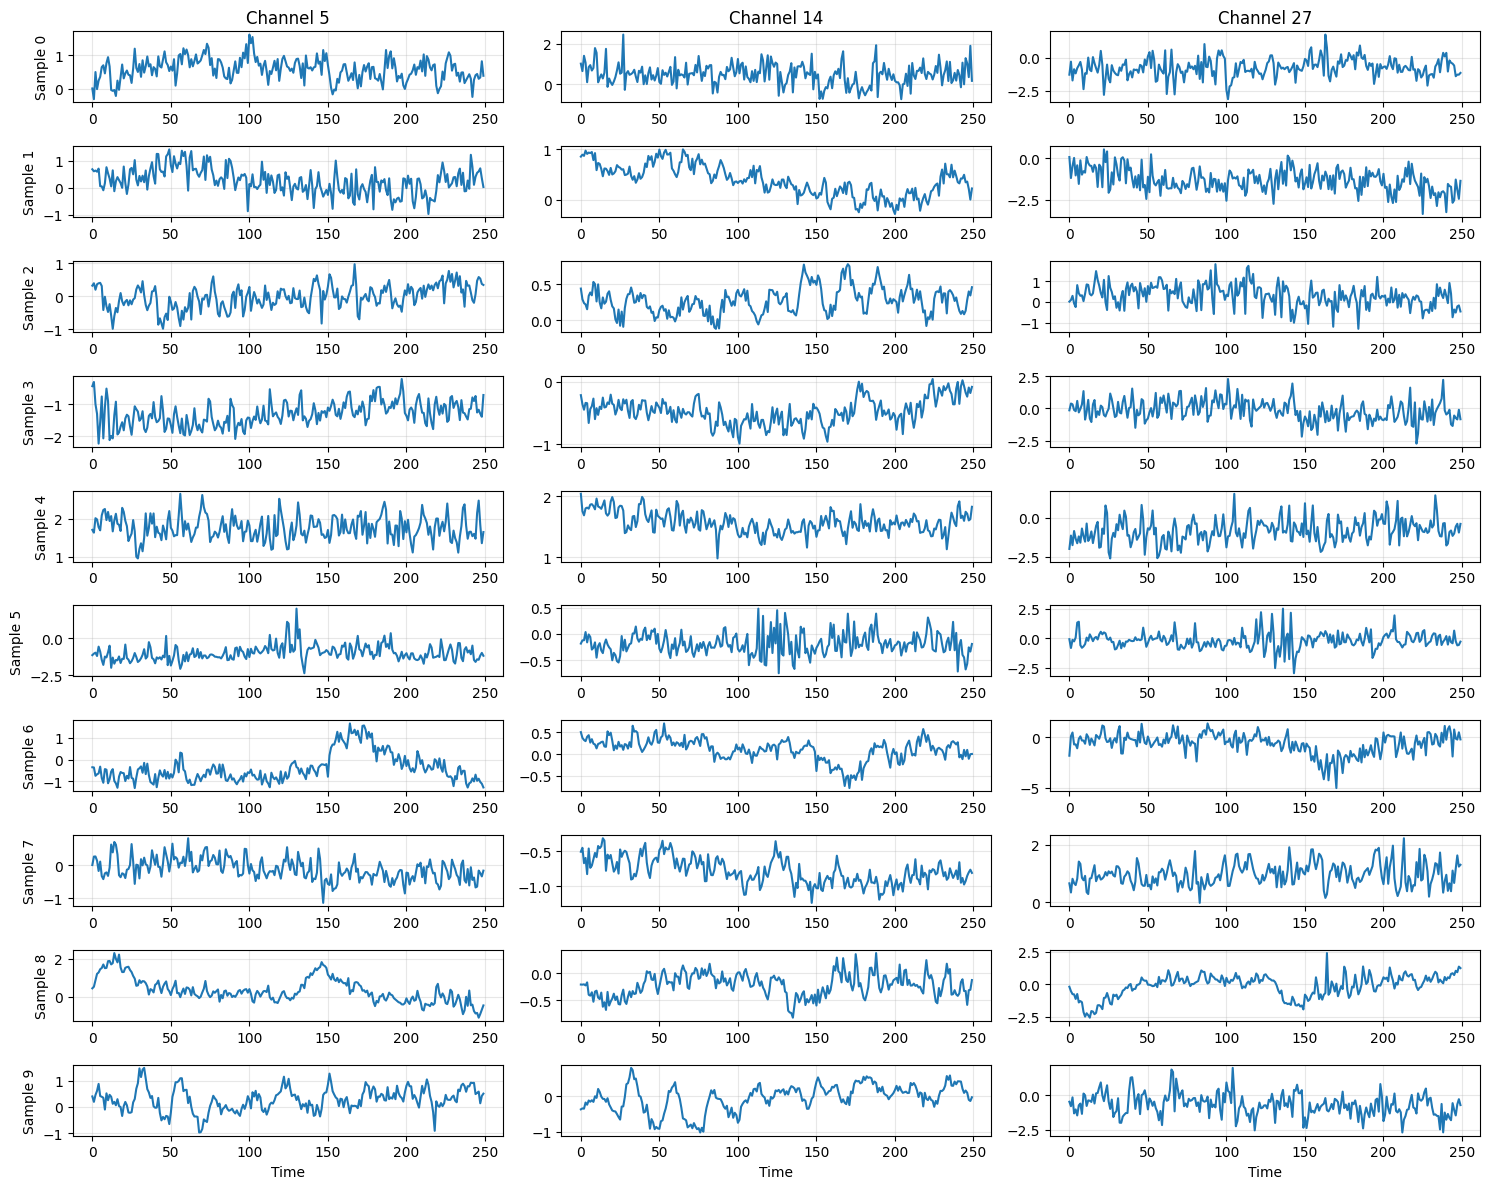

In [34]:
# Get a batch from validation loader
for i, batch in enumerate(train_loader):
    if i== 4:
        data = batch['target']
        break


# Select 10 samples and 3 channels to plot
n_samples = 10
n_channels = 3
channel_indices = [5, 14, 27]  # first, middle, last channels

fig, axes = plt.subplots(n_samples, n_channels, figsize=(15, 12))
time = np.arange(data.shape[2])

for i in range(n_samples):
    for j, ch_idx in enumerate(channel_indices):
        ax = axes[i, j]
        ax.plot(time, data[i, ch_idx, :].cpu().numpy())
        
        if i == 0:
            ax.set_title(f'Channel {ch_idx}')
        if i == n_samples - 1:
            ax.set_xlabel('Time')
        if j == 0:
            ax.set_ylabel(f'Sample {i}')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Checking 500 samples for duplicates and high correlations...

Exact duplicates found: 0

Computing pairwise correlations (this may take a moment)...

Pairs with correlation > 0.85: 3

Top 10 most correlated pairs:
  Sample 106 - Sample 351: correlation = 0.8713
  Sample 245 - Sample 487: correlation = 0.8679
  Sample 106 - Sample 270: correlation = 0.8522


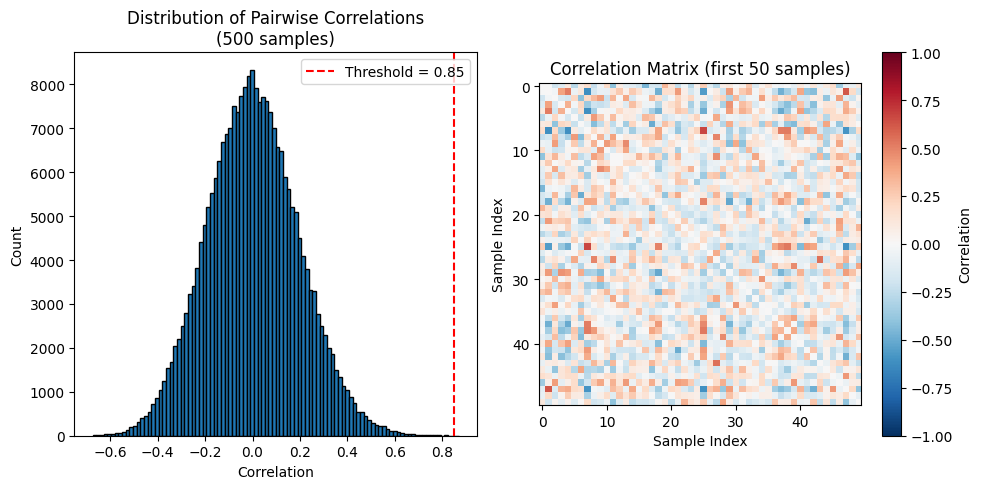

In [30]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr
samples = val_samples
# Use a subset of samples for faster computation
n_check = min(500, len(samples))
# Shuffle samples to get a random subset
np.random.shuffle(samples)
samples_to_check = samples[:n_check]

print(f"Checking {n_check} samples for duplicates and high correlations...")

# Check for exact duplicates
unique_samples = np.unique(samples_to_check, axis=0)
n_duplicates = n_check - len(unique_samples)
print(f"\nExact duplicates found: {n_duplicates}")

# Compute pairwise correlation matrix
print("\nComputing pairwise correlations (this may take a moment)...")
correlations = np.corrcoef(samples_to_check)

# Mask out diagonal (self-correlation = 1)
np.fill_diagonal(correlations, 0)

# Find highly correlated pairs (correlation > 0.95)
high_corr_threshold = 0.85
high_corr_pairs = np.argwhere(correlations > high_corr_threshold)

# Remove duplicate pairs (i,j) and (j,i)
high_corr_pairs = high_corr_pairs[high_corr_pairs[:, 0] < high_corr_pairs[:, 1]]

print(f"\nPairs with correlation > {high_corr_threshold}: {len(high_corr_pairs)}")

if len(high_corr_pairs) > 0:
    print("\nTop 10 most correlated pairs:")
    corr_values = [correlations[i, j] for i, j in high_corr_pairs]
    sorted_indices = np.argsort(corr_values)[::-1][:10]
    for idx in sorted_indices:
        i, j = high_corr_pairs[idx]
        print(f"  Sample {i} - Sample {j}: correlation = {correlations[i, j]:.4f}")

# Plot correlation distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(correlations.ravel(), bins=100, edgecolor='black')
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title(f'Distribution of Pairwise Correlations\n({n_check} samples)')
plt.axvline(x=high_corr_threshold, color='r', linestyle='--', label=f'Threshold = {high_corr_threshold}')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(correlations[:50, :50], cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix (first 50 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')

plt.tight_layout()
plt.show()

Computing cross-correlation between 250 train samples and 250 val samples...
  Processed 50/250 train samples...
  Processed 100/250 train samples...
  Processed 150/250 train samples...
  Processed 200/250 train samples...
  Processed 250/250 train samples...

Cross-pairs with correlation > 0.85: 3
Max cross-correlation: 0.8805
Mean cross-correlation: 0.0017

Top 10 most correlated cross-pairs (train-val):
  Train 27 - Val 169: correlation = 0.8805
  Train 219 - Val 20: correlation = 0.8699
  Train 36 - Val 196: correlation = 0.8563
  Train 27 - Val 145: correlation = 0.8050
  Train 79 - Val 6: correlation = 0.8036
  Train 70 - Val 19: correlation = 0.7851
  Train 194 - Val 222: correlation = 0.7743
  Train 147 - Val 230: correlation = 0.7617
  Train 10 - Val 43: correlation = 0.7564
  Train 67 - Val 6: correlation = 0.7519


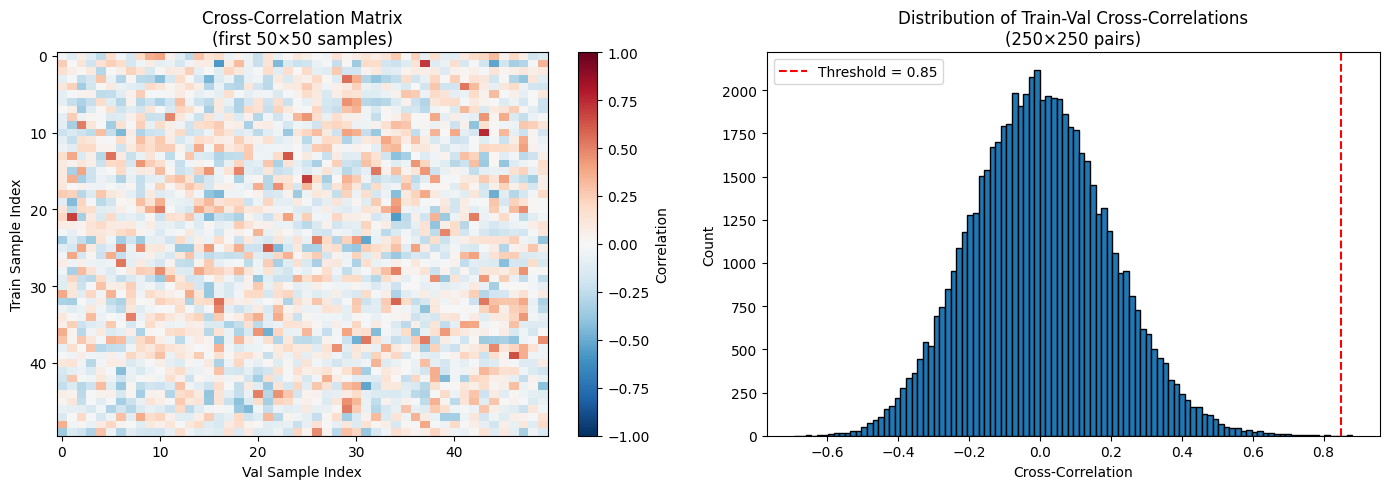

In [31]:
# Check cross-correlation between train and val samples
n_train = min(250, len(train_samples))
n_val = min(250, len(val_samples))

print(f"Computing cross-correlation between {n_train} train samples and {n_val} val samples...")

# Select random subsets
train_subset = train_samples[np.random.choice(len(train_samples), n_train, replace=False)]
val_subset = val_samples[np.random.choice(len(val_samples), n_val, replace=False)]

# Compute cross-correlation matrix
cross_correlations = np.zeros((n_train, n_val))
for i in range(n_train):
    for j in range(n_val):
        cross_correlations[i, j] = np.corrcoef(train_subset[i], val_subset[j])[0, 1]
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{n_train} train samples...")

# Find highly correlated cross-pairs
high_cross_corr_threshold = 0.85
high_cross_corr_pairs = np.argwhere(cross_correlations > high_cross_corr_threshold)

print(f"\nCross-pairs with correlation > {high_cross_corr_threshold}: {len(high_cross_corr_pairs)}")
print(f"Max cross-correlation: {cross_correlations.max():.4f}")
print(f"Mean cross-correlation: {cross_correlations.mean():.4f}")

if len(high_cross_corr_pairs) > 0:
    print("\nTop 10 most correlated cross-pairs (train-val):")
    flat_corr = cross_correlations.ravel()
    top_10_indices = np.argsort(flat_corr)[::-1][:10]
    for idx in top_10_indices:
        i = idx // n_val
        j = idx % n_val
        print(f"  Train {i} - Val {j}: correlation = {cross_correlations[i, j]:.4f}")

# Plot cross-correlation matrix and distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap of cross-correlation matrix (subset)
im = axes[0].imshow(cross_correlations[:50, :50], cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0].set_xlabel('Val Sample Index')
axes[0].set_ylabel('Train Sample Index')
axes[0].set_title('Cross-Correlation Matrix\n(first 50×50 samples)')
plt.colorbar(im, ax=axes[0], label='Correlation')

# Distribution of cross-correlations
axes[1].hist(cross_correlations.ravel(), bins=100, edgecolor='black')
axes[1].axvline(x=high_cross_corr_threshold, color='r', linestyle='--', label=f'Threshold = {high_cross_corr_threshold}')
axes[1].set_xlabel('Cross-Correlation')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Distribution of Train-Val Cross-Correlations\n({n_train}×{n_val} pairs)')
axes[1].legend()

plt.tight_layout()
plt.show()